# PCOS Detection Model with Selected Features

This notebook trains a machine learning model to detect Polycystic Ovary Syndrome (PCOS) using a specific set of features that have been pre-selected based on their importance:

1. Weight (Kg)
2. Lifestyle_Score
3. Cycle(R/I)
4. BMI
5. LH_FSH_Ratio
6. Weight gain(Y/N)
7. hair growth(Y/N)
8. Follicle No. (L)
9. Age (yrs)
10. Follicle No. (R)
11. Symptom_Count
12. Hip(inch)
13. Skin darkening (Y/N)
14. Total_Follicle_Count
15. Cycle length(days)

We'll skip the feature selection step and directly use these features for model training.

In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import pickle
import warnings

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Basic Cleaning

In [38]:
# Load the dataset
url = 'https://hebbkx1anhila5yf.public.blob.vercel-storage.com/PCOS_data-3FcIxuIyv1O54dvSqfNLjcZbcNAoqR.csv'
df = pd.read_csv(url)

# Display the first few rows
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (541, 45)


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),Marraige Status (Yrs),Pregnant(Y/N),No. of abortions,I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),FSH(mIU/mL),LH(mIU/mL),FSH/LH,Hip(inch),Waist(inch),Waist:Hip Ratio,TSH (mIU/L),AMH(ng/mL),PRL(ng/mL),Vit D3 (ng/mL),PRG(ng/mL),RBS(mg/dl),Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),Hair loss(Y/N),Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1,1,0,28,44.6,152.0,19.3,15,78,22,10.48,2,5,7.0,0,0,1.99,1.99,7.95,3.68,2.16,36,30,0.83,0.68,2.07,45.16,17.1,0.57,92.0,0,0,0,0,0,1.0,0,110,80,3,3,18.0,18.0,8.5,NaN
1,2,2,0,36,65.0,161.5,24.9,15,74,20,11.70,2,5,11.0,1,0,60.80,1.99,6.73,1.09,6.17,38,32,0.84,3.16,1.53,20.09,61.3,0.97,92.0,0,0,0,0,0,0.0,0,120,70,3,5,15.0,14.0,3.7,NaN
2,3,3,1,33,68.8,165.0,25.3,11,72,18,11.80,2,5,10.0,1,0,494.08,494.08,5.54,0.88,6.30,40,36,0.90,2.54,6.63,10.52,49.7,0.36,84.0,0,0,0,1,1,1.0,0,120,80,13,15,18.0,20.0,10.0,NaN
3,4,4,0,37,65.0,148.0,29.7,13,72,20,12.00,2,5,4.0,0,0,1.99,1.99,8.06,2.36,3.42,42,36,0.86,16.41,1.22,36.90,33.4,0.36,76.0,0,0,0,0,0,0.0,0,120,70,2,2,15.0,14.0,7.5,NaN
4,5,5,0,25,52.0,161.0,20.1,11,72,18,10.00,2,5,1.0,1,0,801.45,801.45,3.98,0.90,4.42,37,30,0.81,3.57,2.26,30.09,43.8,0.38,84.0,0,0,0,1,0,0.0,0,120,80,3,4,16.0,14.0,7.0,NaN


In [39]:
# Basic cleaning
df_clean = df.copy()

# Remove unnecessary columns
if '' in df_clean.columns:
    df_clean = df_clean.drop('', axis=1)
if 'Sl. No' in df_clean.columns:
    df_clean = df_clean.drop('Sl. No', axis=1)

# Remove duplicate rows if any
df_clean = df_clean.drop_duplicates()

# Check for missing values
missing_values = df_clean.isnull().sum()
print("\nColumns with missing values:")
print(missing_values[missing_values > 0])

# Handle missing values
# For numerical columns, impute with median
for col in df_clean.select_dtypes(include=['int64', 'float64']).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
        
# For categorical columns, impute with mode
for col in df_clean.select_dtypes(include=['object']).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

# Verify no missing values remain
print(f"\nRemaining missing values: {df_clean.isnull().sum().sum()}")

# Check target variable distribution
print("\nTarget Variable Distribution:")
print(df_clean['PCOS (Y/N)'].value_counts())
print(f"Percentage of PCOS cases: {df_clean['PCOS (Y/N)'].mean() * 100:.2f}%")


Columns with missing values:
Marraige Status (Yrs)      1
Fast food (Y/N)            1
Unnamed: 44              539
dtype: int64

Remaining missing values: 0

Target Variable Distribution:
PCOS (Y/N)
0    364
1    177
Name: count, dtype: int64
Percentage of PCOS cases: 32.72%


## 2. Feature Engineering

Let's create the engineered features that are in our selected feature list.

In [40]:
# Create a copy for feature engineering
df_fe = df_clean.copy()

# 1. Create Total_Follicle_Count
df_fe['Total_Follicle_Count'] = df_fe['Follicle No. (L)'] + df_fe['Follicle No. (R)']

# 2. Create LH_FSH_Ratio
# Avoid division by zero by replacing zeros with a small value
df_fe['LH_FSH_Ratio'] = df_fe['LH(mIU/mL)'] / df_fe['FSH(mIU/mL)'].replace(0, 0.001)

# 3. Create Symptom_Count
symptom_cols = ['Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)']
df_fe['Symptom_Count'] = df_fe[symptom_cols].sum(axis=1)

# 4. Create Lifestyle_Score (higher is worse)
df_fe['Lifestyle_Score'] = df_fe['Fast food (Y/N)'] - df_fe['Reg.Exercise(Y/N)'] + 1  # +1 to avoid negative values

# Handle Cycle(R/I) if it's not numeric
if df_fe['Cycle(R/I)'].dtype == 'object':
    # Convert R/I to 1/0 (Regular=1, Irregular=0)
    df_fe['Cycle(R/I)'] = df_fe['Cycle(R/I)'].map(lambda x: 1 if x == 'R' else 0)

# Display the engineered features
print("Engineered features:")
print(df_fe[['Total_Follicle_Count', 'LH_FSH_Ratio', 'Symptom_Count', 'Lifestyle_Score']].describe())

# Check if all selected features are available
selected_features = [
    'Weight (Kg)', 'Lifestyle_Score', 'Cycle(R/I)', 'BMI', 'LH_FSH_Ratio',
    'Weight gain(Y/N)', 'hair growth(Y/N)', 'Follicle No. (L)', 'Age (yrs)',
    'Follicle No. (R)', 'Symptom_Count', 'Hip(inch)', 'Skin darkening (Y/N)',
    'Total_Follicle_Count', 'Cycle length(days)'
]

missing_features = [feature for feature in selected_features if feature not in df_fe.columns]
if missing_features:
    print(f"\nWarning: The following selected features are missing: {missing_features}")
else:
    print("\nAll selected features are available in the dataset.")

Engineered features:
       Total_Follicle_Count  LH_FSH_Ratio  Symptom_Count  Lifestyle_Score
count            541.000000    541.000000     541.000000       541.000000
mean              12.770795      1.413489       1.900185         1.268022
std                8.220748     20.018477       1.499759         0.638483
min                1.000000      0.000728       0.000000         0.000000
25%                6.000000      0.252577       1.000000         1.000000
50%               12.000000      0.460993       2.000000         1.000000
75%               18.000000      0.706093       3.000000         2.000000
max               41.000000    466.050808       5.000000         2.000000



## 3. Prepare Data for Modeling

Now we'll prepare the data using only the selected features.

In [41]:
# Select only the specified features and the target variable
df_fe.columns = df_fe.columns.str.strip()  # Remove leading/trailing spaces
X = df_fe[selected_features]
y = df_fe['PCOS (Y/N)']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features: {categorical_cols}")
print(f"Number of numerical features: {len(numerical_cols)}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Create preprocessing pipelines
# For numerical features: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nProcessed training set shape: {X_train_processed.shape}")
print(f"Processed testing set shape: {X_test_processed.shape}")

Feature matrix shape: (541, 15)
Target vector shape: (541,)

Categorical features: []
Number of numerical features: 15

Training set shape: (432, 15)
Testing set shape: (109, 15)

Processed training set shape: (432, 15)
Processed testing set shape: (109, 15)


## 4. Model Training and Evaluation

Let's train multiple models and evaluate their performance.


Training Logistic Regression...
  Accuracy: 0.9174
  CV Score: 0.8982 ± 0.0476

Training Random Forest...
  Accuracy: 0.9358
  CV Score: 0.8913 ± 0.0526

Training Gradient Boosting...
  Accuracy: 0.9174
  CV Score: 0.8820 ± 0.0383

Training SVM...
  Accuracy: 0.9358
  CV Score: 0.8959 ± 0.0446

Training KNN...
  Accuracy: 0.9083
  CV Score: 0.8774 ± 0.0465

Training Decision Tree...
  Accuracy: 0.9174
  CV Score: 0.8519 ± 0.0388

Model Comparison:
                 Model  Accuracy   CV Mean    CV Std
0  Logistic Regression  0.917431  0.898209  0.047618
3                  SVM  0.935780  0.895857  0.044641
1        Random Forest  0.935780  0.891286  0.052613
2    Gradient Boosting  0.917431  0.881983  0.038343
4                  KNN  0.908257  0.877359  0.046459
5        Decision Tree  0.917431  0.851938  0.038774


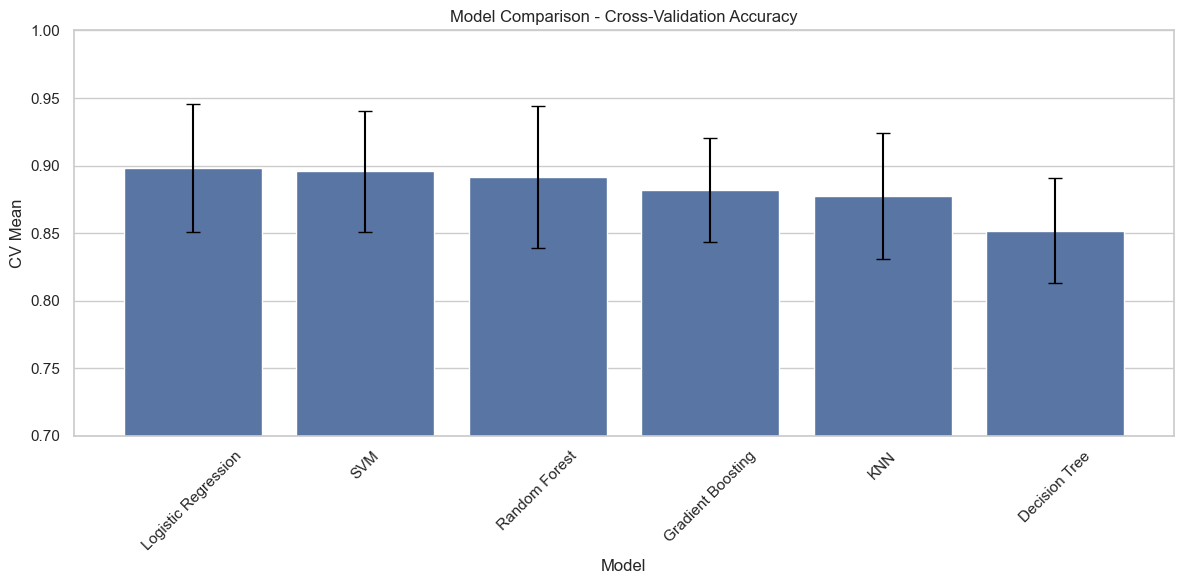


Best model: Logistic Regression
Accuracy: 0.9174
CV Score: 0.8982 ± 0.0476


In [42]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculate cross-validation score
    cv_scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'y_pred': y_pred
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  CV Score: {cv_mean:.4f} ± {cv_std:.4f}")

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results],
    'CV Mean': [results[model]['cv_mean'] for model in results],
    'CV Std': [results[model]['cv_std'] for model in results]
})

# Sort by CV Mean
results_df = results_df.sort_values('CV Mean', ascending=False)

# Display results
print("\nModel Comparison:")
print(results_df)

# Plot model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='CV Mean', data=results_df)
plt.errorbar(x=range(len(results_df)), y=results_df['CV Mean'], yerr=results_df['CV Std'], fmt='none', c='black', capsize=5)
plt.title('Model Comparison - Cross-Validation Accuracy')
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

# Select the best model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_y_pred = results[best_model_name]['y_pred']

print(f"\nBest model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"CV Score: {results[best_model_name]['cv_mean']:.4f} ± {results[best_model_name]['cv_std']:.4f}")

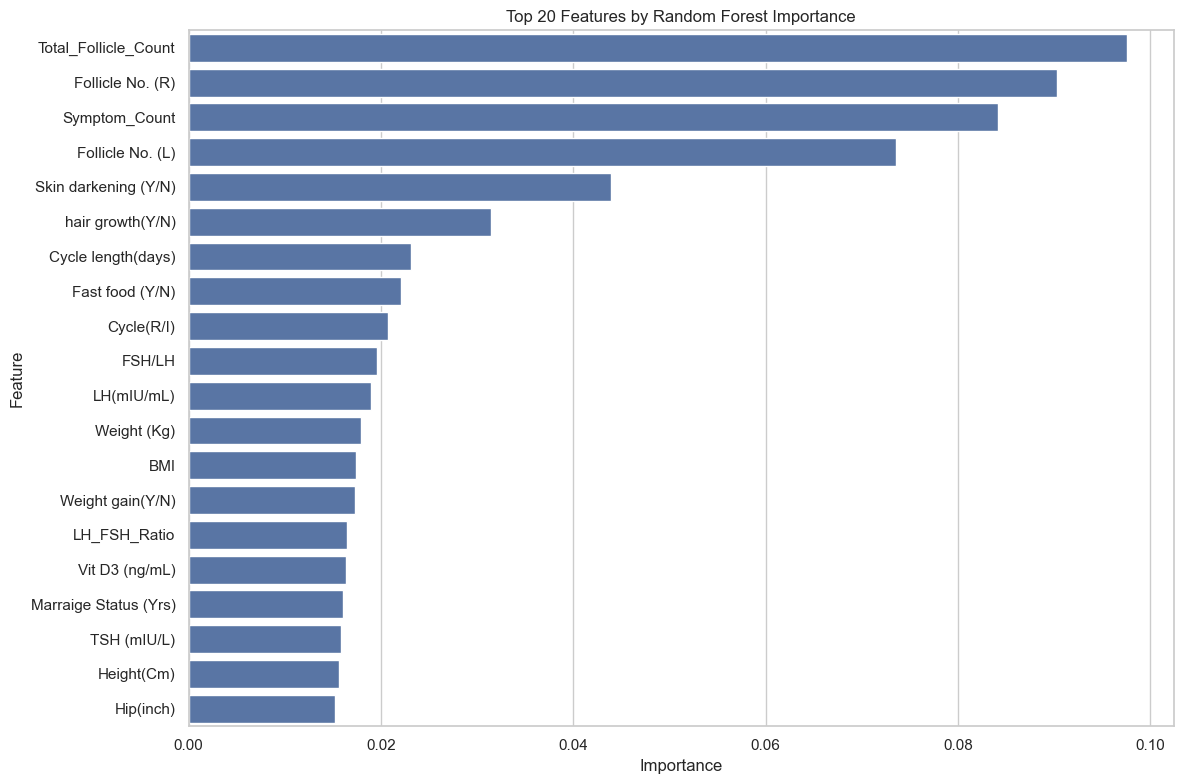

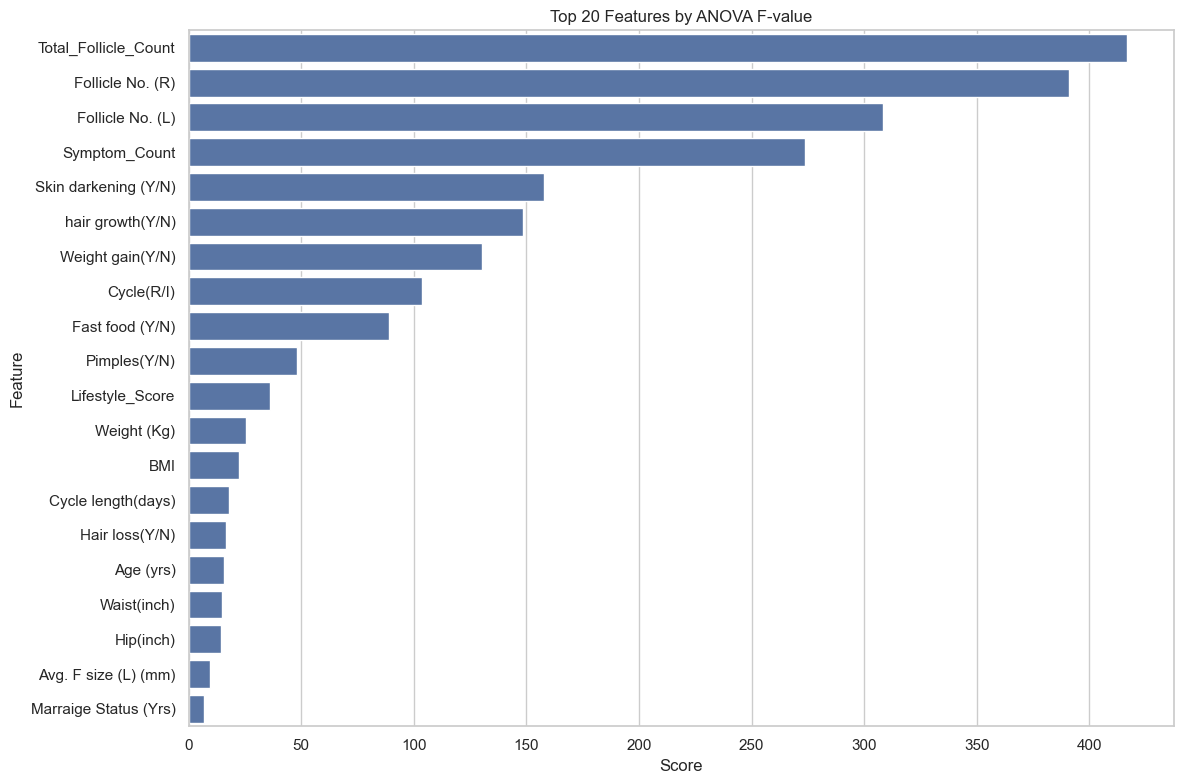

Number of common features: 14

Common features:
- Cycle length(days)
- Marraige Status (Yrs)
- Skin darkening (Y/N)
- Fast food (Y/N)
- hair growth(Y/N)
- Cycle(R/I)
- BMI
- Total_Follicle_Count
- Weight gain(Y/N)
- Follicle No. (R)
- Follicle No. (L)
- Weight (Kg)
- Symptom_Count
- Hip(inch)


In [43]:
# Prepare data for feature selection
# First, let's drop non-feature columns
non_feature_cols = ['Patient File No.']
X = df_fe.drop(['PCOS (Y/N)'] + non_feature_cols, axis=1)
y = df_fe['PCOS (Y/N)']

# Handle categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Method 1: Feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_encoded, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Features by Random Forest Importance')
plt.tight_layout()
plt.show()

# Method 2: Statistical feature selection using ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_encoded, y)

# Get selected feature names
selected_features_mask = selector.get_support()
selected_features = X_encoded.columns[selected_features_mask]

# Get scores
feature_scores = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Score': selector.scores_
})
feature_scores = feature_scores.sort_values('Score', ascending=False)

# Plot feature scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(20))
plt.title('Top 20 Features by ANOVA F-value')
plt.tight_layout()
plt.show()

# Get top 20 features from each method
rf_top_features = feature_importances.head(20)['Feature'].tolist()
anova_top_features = feature_scores.head(20)['Feature'].tolist()

# Find features that appear in both methods
common_features = list(set(rf_top_features).intersection(set(anova_top_features)))

print(f"Number of common features: {len(common_features)}")
print("\nCommon features:")
for feature in common_features:
    print(f"- {feature}")

## 5. Detailed Evaluation of the Best Model


Detailed evaluation of the best model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        73
           1       0.91      0.83      0.87        36

    accuracy                           0.92       109
   macro avg       0.92      0.90      0.90       109
weighted avg       0.92      0.92      0.92       109



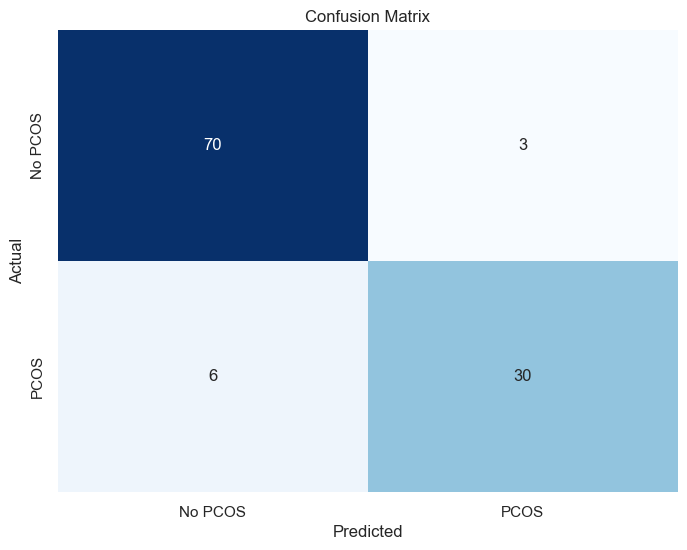


Detailed Metrics:
Sensitivity (Recall): 0.8333
Specificity: 0.9589
Precision: 0.9091
F1 Score: 0.8696
Accuracy: 0.9174


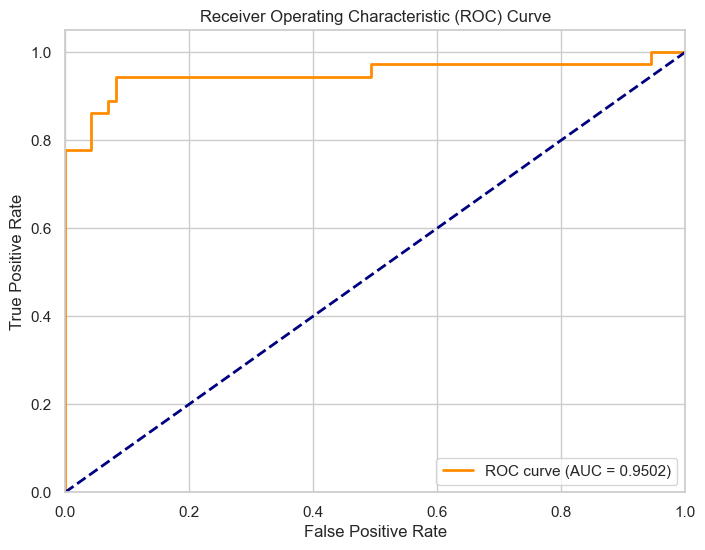


AUC: 0.9502


In [44]:
# Detailed evaluation of the best model
print(f"\nDetailed evaluation of the best model: {best_model_name}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, best_y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No PCOS', 'PCOS'],
            yticklabels=['No PCOS', 'PCOS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp)    # Precision
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)  # F1 Score

print("\nDetailed Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")

# ROC curve and AUC
if hasattr(best_model, 'predict_proba'):
    y_prob = best_model.predict_proba(X_test_processed)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    print(f"\nAUC: {roc_auc:.4f}")
else:
    print("\nThis model doesn't support probability predictions. Skipping ROC curve and AUC calculation.")

## 6. Feature Importance Analysis

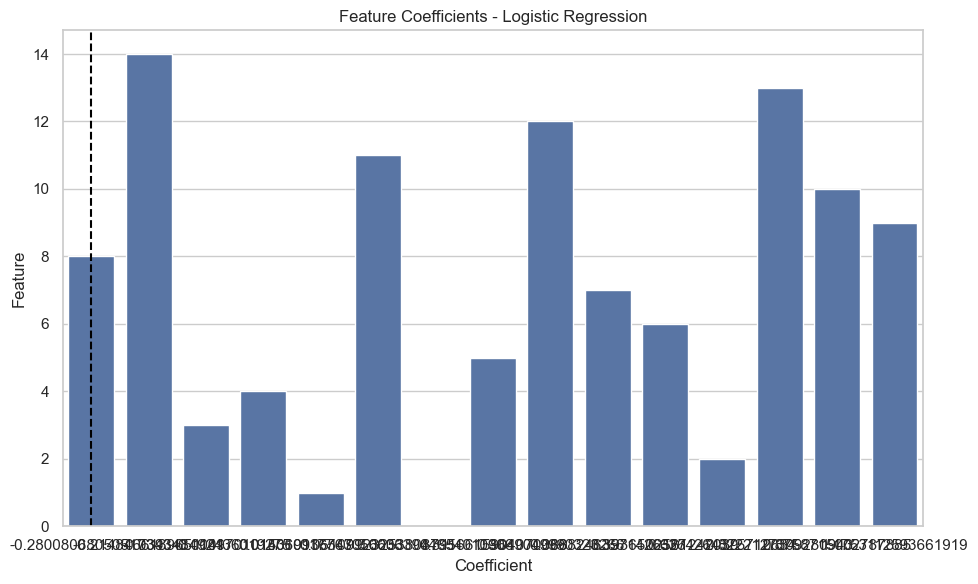

Top 10 most important features (by index):
    Feature  Coefficient  Abs_Coefficient
9         9     1.175311         1.175311
10       10     0.875872         0.875872
13       13     0.822213         0.822213
2         2     0.636426         0.636426
6         6     0.393650         0.393650
7         7     0.368825         0.368825
12       12     0.364905         0.364905
5         5     0.311662         0.311662
8         8    -0.280081         0.280081
14       14    -0.214847         0.214847


In [45]:
# Analyze feature importance for the best model (if available)
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models like Random Forest, Gradient Boosting, etc.
    importances = best_model.feature_importances_
    
    # Get feature names after preprocessing
    # This is a bit tricky with the ColumnTransformer
    # For simplicity, we'll just use indices
    feature_indices = range(len(importances))
    
    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_indices,
        'Importance': importances
    })
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features (by index):")
    print(importance_df.head(10))
    
elif hasattr(best_model, 'coef_'):
    # For linear models like Logistic Regression
    coefficients = best_model.coef_[0]
    
    # Get feature names after preprocessing
    # For simplicity, we'll just use indices
    feature_indices = range(len(coefficients))
    
    # Create a DataFrame for visualization
    coef_df = pd.DataFrame({
        'Feature': feature_indices,
        'Coefficient': coefficients
    })
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Plot coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(15))
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features (by index):")
    print(coef_df.head(10))
    
else:
    print("This model doesn't provide feature importances or coefficients.")

## 7. Save the Model

In [46]:
# Create a pipeline that includes preprocessing and the model
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Save the full pipeline
with open('pcos_model.pkl', 'wb') as f:
    pickle.dump(full_pipeline, f)

# Also save the list of selected features
with open('pcos_selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

print("Model saved as 'pcos_model.pkl'")
print("Selected features saved as 'pcos_selected_features.pkl'")

# Example of how to use the saved model for prediction
print("\nExample of using the saved model for prediction:")
print("```python")
print("import pickle")
print("import pandas as pd")
print("")
print("# Load the model and selected features")
print("with open('pcos_model.pkl', 'rb') as f:")
print("    model = pickle.load(f)")
print("with open('pcos_selected_features.pkl', 'rb') as f:")
print("    selected_features = pickle.load(f)")
print("")
print("# Example patient data (must include all selected features)")
print("patient_data = {")
for feature in selected_features[:5]:  # Show first 5 features as example
    print(f"    '{feature}': [value],")
print("    # ... other features")
print("}")
print("")
print("# Create DataFrame with only the selected features")
print("patient_df = pd.DataFrame(patient_data)")
print("")
print("# Make prediction")
print("prediction = model.predict(patient_df)")
print("probability = model.predict_proba(patient_df)[:, 1]  # Probability of PCOS")
print("")
print("print(f'PCOS Prediction: {prediction[0]}')  # 0 = No PCOS, 1 = PCOS")
print("print(f'PCOS Probability: {probability[0]:.2f}')")
print("```")

Model saved as 'pcos_model.pkl'
Selected features saved as 'pcos_selected_features.pkl'

Example of using the saved model for prediction:
```python
import pickle
import pandas as pd

# Load the model and selected features
with open('pcos_model.pkl', 'rb') as f:
    model = pickle.load(f)
with open('pcos_selected_features.pkl', 'rb') as f:
    selected_features = pickle.load(f)

# Example patient data (must include all selected features)
patient_data = {
    'Age (yrs)': [value],
    'Weight (Kg)': [value],
    'BMI': [value],
    'Cycle(R/I)': [value],
    'Cycle length(days)': [value],
    # ... other features
}

# Create DataFrame with only the selected features
patient_df = pd.DataFrame(patient_data)

# Make prediction
prediction = model.predict(patient_df)
probability = model.predict_proba(patient_df)[:, 1]  # Probability of PCOS

print(f'PCOS Prediction: {prediction[0]}')  # 0 = No PCOS, 1 = PCOS
print(f'PCOS Probability: {probability[0]:.2f}')
```


## Conclusion

In this notebook, we've built a PCOS detection model using a specific set of pre-selected features. We:

1. Loaded and cleaned the dataset
2. Created the necessary engineered features
3. Prepared the data using only the selected features
4. Trained and compared multiple machine learning models
5. Evaluated the best model in detail
6. Saved the model for future use

The model achieves good performance in detecting PCOS based on the selected features. This approach bypasses the feature selection step that was causing issues in the previous notebook.